In [1]:
import subprocess
import shlex
import re
import json

import numpy as np
import multiprocessing as mp

from matplotlib import pyplot as plt
from scipy import stats
from tqdm import tqdm

In [2]:
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 400

def show():
    plt.savefig(f"almost-infinite.{show.fig_counter}.pdf", dpi='figure', transparent=True, bbox_inches='tight')
    show.fig_counter += 1
    show.plt_show()

show.fig_counter = 0
show.plt_show = plt.show

plt.show = show

In [3]:
import scipy.special as sp

def preston(A_on_sigma_sq, nu):
    a = np.sqrt(A_on_sigma_sq / np.pi)
    
    nu_eff = nu * np.log(1.0 / nu) / (1.0 - nu)
    
    num = 2.0 * np.pi * a * (1.0 - nu_eff) * sp.i1e(a)
    
    denom = (1.0 / np.sqrt(nu_eff)) * sp.i1e(a) * sp.k0e(np.sqrt(nu_eff) * a) / sp.k1e(np.sqrt(nu_eff) * a) + sp.i0e(a)
    
    return (nu_eff * A_on_sigma_sq + num / denom)

def s_contig(A_eff, deme, nu, sigma_sq):
    return sigma_sq * preston(A_eff * deme / sigma_sq, nu)

In [4]:
BIODIVERSITY_PATTERN = re.compile(r"The simulation resulted in a biodiversity of (\d+) unique species\.")
TIMING_PATTERN = re.compile(r"The simulation finished at time (\d+\.\d+) after (\d+) steps\.")

In [5]:
target_directory = json.loads(subprocess.run("cargo metadata --format-version 1".split(), capture_output=True).stdout)["target_directory"]

In [6]:
def simulate_almost_infinite_scenario(speciation=0.1, seed=42, radius=18, sigma=10.0):
    config = "".join(f"""
    (
        speciation: {speciation},
        sample: 1.0,
        seed: {seed},

        algorithm: Classical(),

        log: None,

        scenario: AlmostInfinite(
            radius: {radius},
            sigma: {sigma},
        ),

        reporters: [
            Plugin(
                library: "{target_directory}/release/deps/libnecsim_plugins_common.so",
                reporters: [Biodiversity()]
            )
        ],
    )
    """.split()).replace(",)", ")").replace(",]", "]")

    # Run the simulation
    result = subprocess.run(shlex.split(
        "cargo run --release --features rustcoalescence-algorithms-monolithic,"
        + f"rustcoalescence-algorithms-independent --quiet -- simulate '{config}'"
    ), check=True, capture_output=True, text=True)

    match = BIODIVERSITY_PATTERN.search(result.stdout)
    biodiversity = int(match.group(1))

    match = TIMING_PATTERN.search(result.stdout)
    time = float(match.group(1))
    steps = int(match.group(2))
        
    return biodiversity, time, steps

In [7]:
def batch_simulation_many_seeds(simulate, seeds, args=tuple(), kwargs=dict(), silent=False):
    results = []

    with tqdm(total=len(seeds), disable=silent) as progress:
        def report_error(err):
            print(err)
        
        def update_progress(result):
            results.append(result)

            progress.update()

        with mp.Pool(mp.cpu_count()) as pool:
            for seed in seeds:
                pool.apply_async(simulate, args, {**kwargs, "seed": seed}, update_progress, report_error)

            pool.close()
            pool.join()
    
    return results

In [8]:
def simulate_almost_infinite_super_batch(speciation=0.1, radii=[10], sigmas=[10.0], size=10):
    Sigmas = []
    Radii = []
    Biodiversities = []

    for radius in radii:
        for sigma in sigmas:
            seeds = np.random.randint(0, np.iinfo("uint64").max, dtype="uint64", size=size)

            Sigmas.append(sigma)
            Radii.append(radius)

            results = batch_simulation_many_seeds(simulate_almost_infinite_scenario, seeds, kwargs={
                "speciation":speciation, "radius":radius, "sigma": sigma
            }, silent=True)
            biodiversities, times, steps = tuple(zip(*results))

            Biodiversities.append(np.mean(biodiversities))
    
    return Sigmas, Radii, Biodiversities

# III. Verify correct convergence of the AlmostInfinite scenario
## III.1. Compute the biodiversity for a mesh of sigmas x radii

In [9]:
Sigmas, Radii, Biodiversities = simulate_almost_infinite_super_batch(speciation=0.1, radii=[
    0, 2, 3, 6, 10, 18, 31, 56, 100, 180, 310, 560
], sigmas=[0.0, 1.0, 1.8, 3.1, 5.6, 10.0, 18.0, 31.0, 56.0, 100.0, 180.0, 310.0, 560.0], size=100)

In [10]:
Expected = [
    s_contig(max(radius*radius*np.pi, 1), 1, 0.1, sigma*sigma) if sigma > 0.0 else max(radius*radius*np.pi, 1)
    for sigma, radius in zip(Sigmas, Radii)
]

## III.2 Plot the expected biodiversity surface

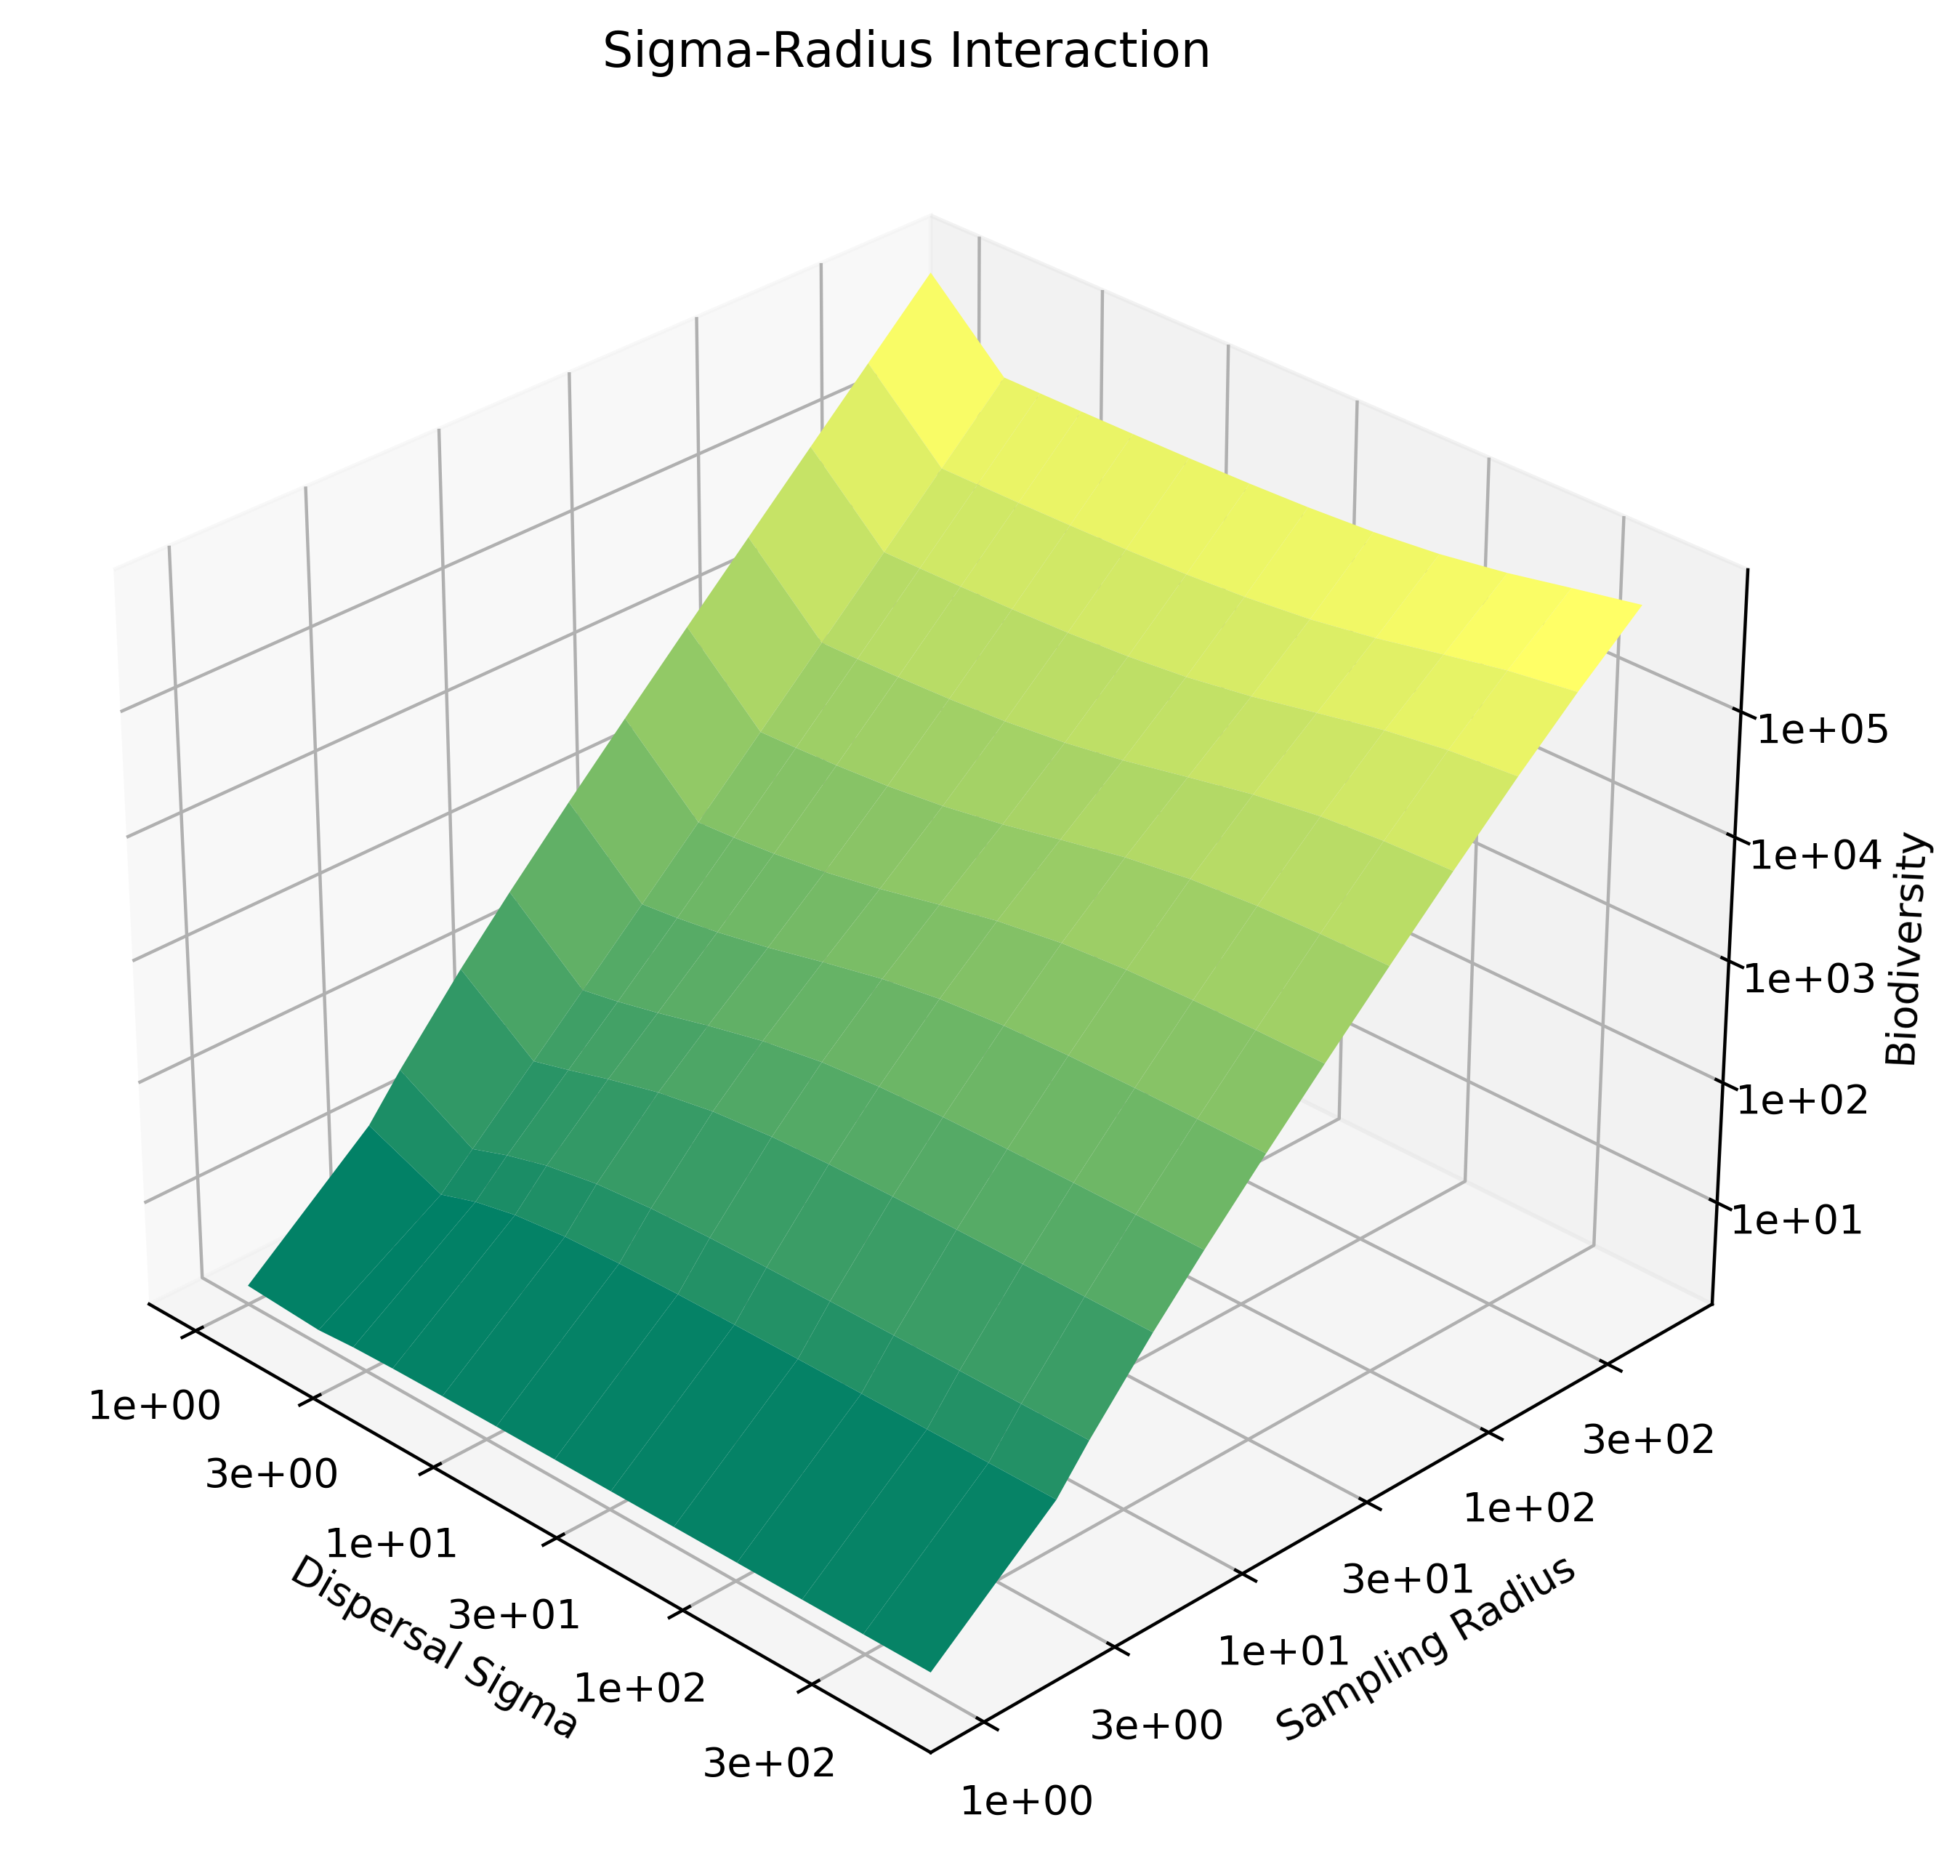

In [11]:
import matplotlib.ticker as mticker

fig, ax = plt.subplots(figsize=(8, 8), subplot_kw={"projection": "3d"})

ax.set_title("Sigma-Radius Interaction")

def log_tick_formatter(val, pos=None):
    return "{:.0e}".format(10**val)

ax.xaxis.set_major_formatter(mticker.FuncFormatter(log_tick_formatter))
ax.yaxis.set_major_formatter(mticker.FuncFormatter(log_tick_formatter))
ax.zaxis.set_major_formatter(mticker.FuncFormatter(log_tick_formatter))

ax.set_xlabel("Dispersal Sigma")
ax.set_ylabel("Sampling Radius")
ax.set_zlabel("Biodiversity")

ax.plot_surface(
    np.log10(np.array(Sigmas).reshape((12, 13)) + 1),
    np.log10(np.array(Radii).reshape((12, 13)) + 1),
    np.log10(np.array(Expected).reshape((12, 13)) + 1),
    antialiased=True, cmap='summer'
)

ax.view_init(30, 315)

plt.show()

## III.3 Plot the effect of dispersal sigma on biodiversity

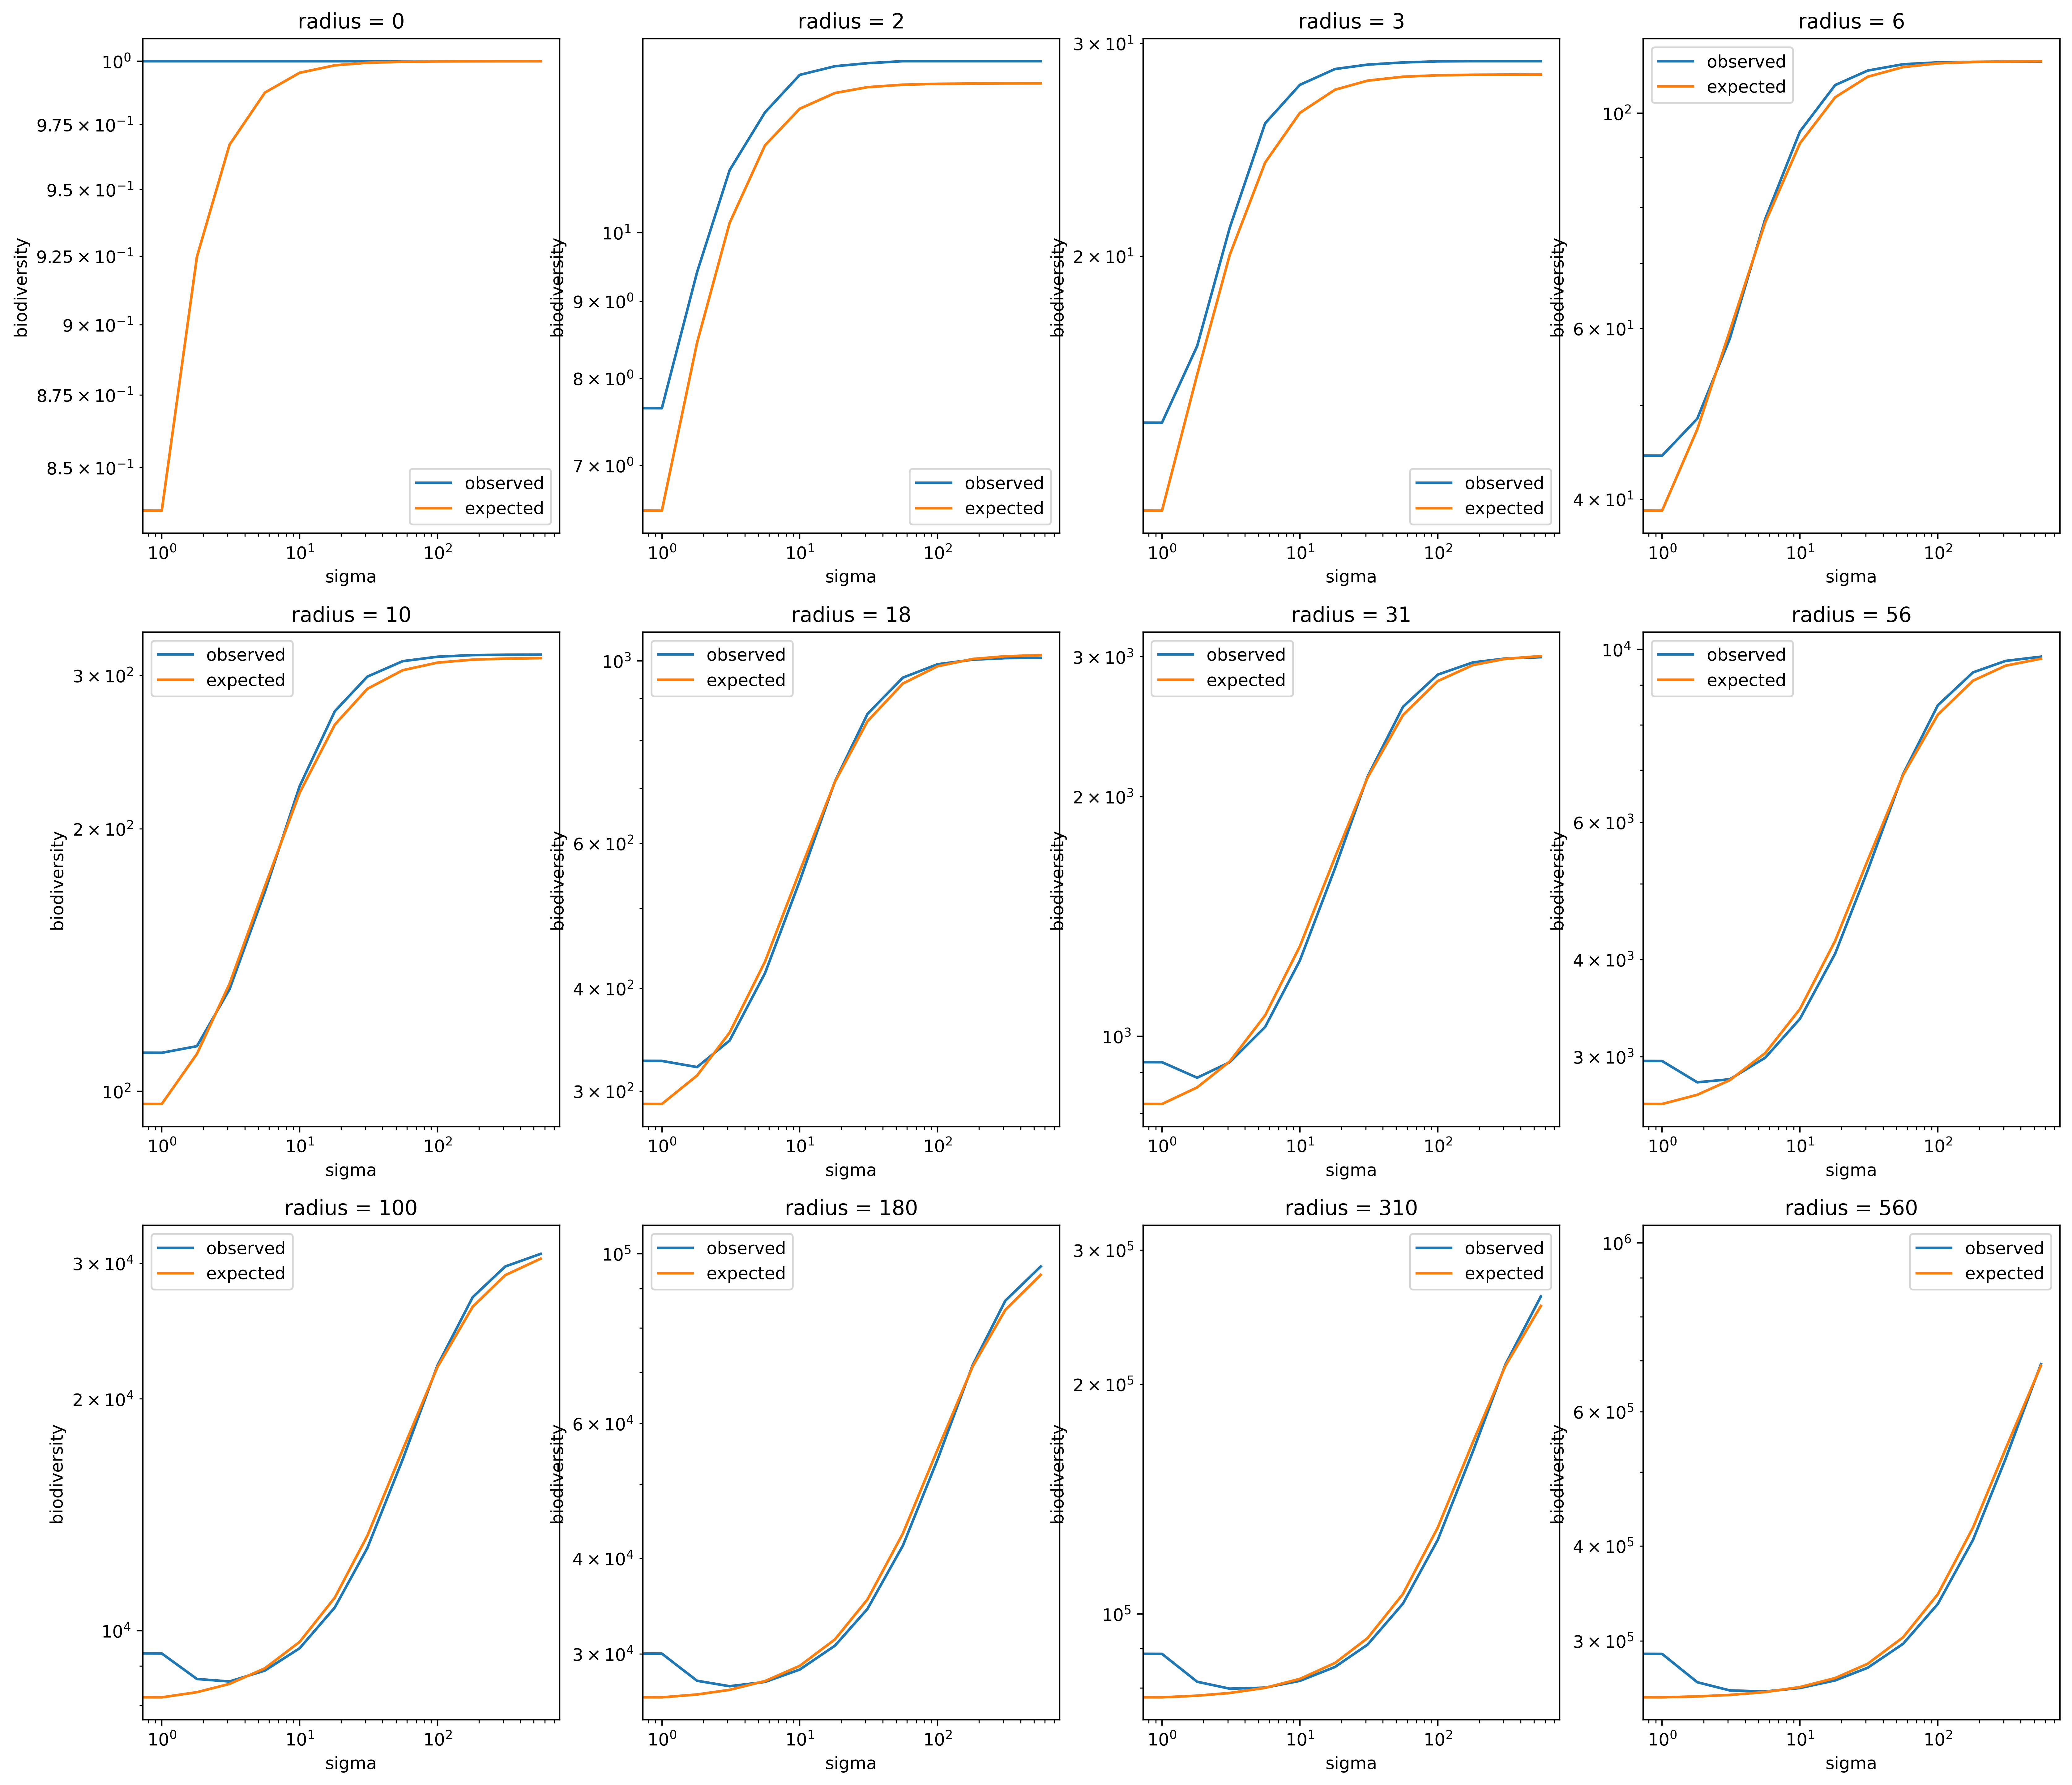

In [12]:
fig, axes = plt.subplots(3, 4, figsize=(20, 18))

for i in range(12):
    ax = axes[i // 4][i % 4]
    
    si = 13 * i
    ei = si + 13
    
    ax.set_title(f"radius = {Radii[si]}")
    ax.set_xlabel('sigma')
    ax.set_ylabel('biodiversity')
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.plot(Sigmas[si:ei], Biodiversities[si:ei], label='observed')
    ax.plot(Sigmas[si:ei], Expected[si:ei], label='expected')
    ax.legend()

plt.show()

## III.4 Plot the effect of dispersal sigmas on biodiversity

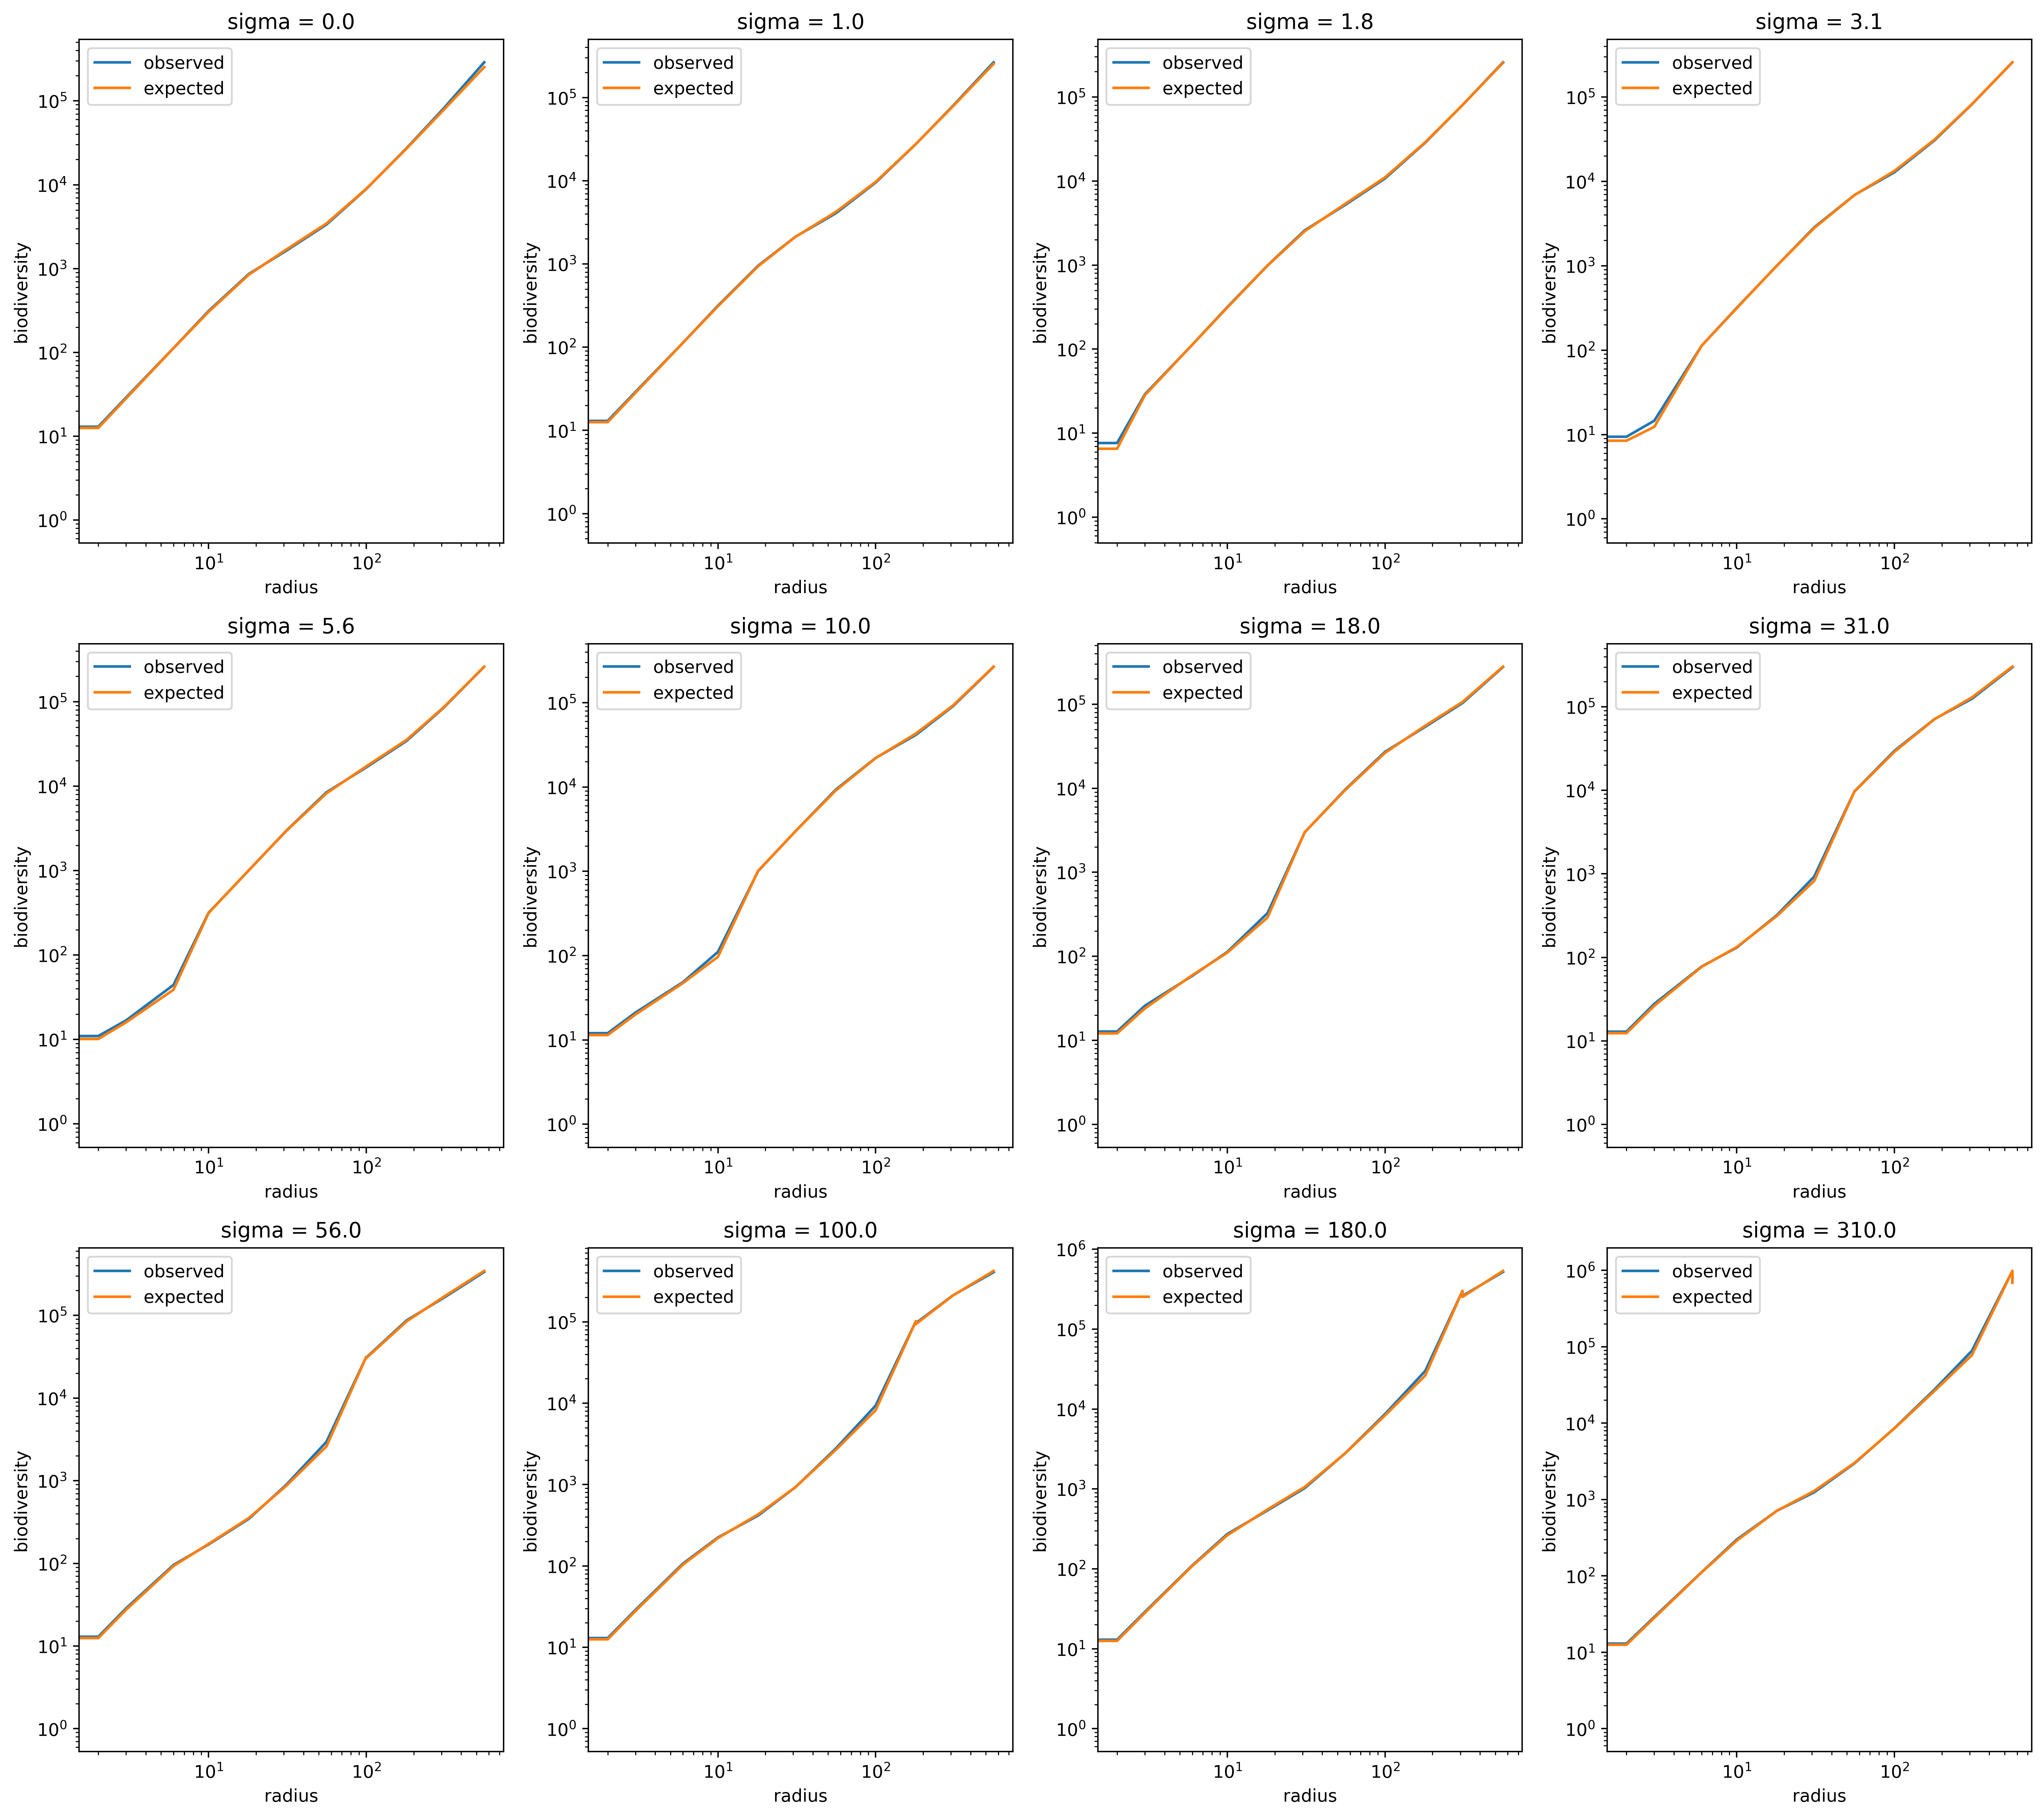

In [13]:
fig, axes = plt.subplots(3, 4, figsize=(20, 18))

for i in range(12): # could be 13
    ax = axes[i // 4][i % 4]
    
    ax.set_title(f"sigma = {Sigmas[i]}")
    ax.set_xlabel('radius')
    ax.set_ylabel('biodiversity')
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.plot(Radii[i::12], Biodiversities[i::12], label='observed')
    ax.plot(Radii[i::12], Expected[i::12], label='expected')
    ax.legend()

plt.show()